<a href="https://colab.research.google.com/github/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDSA Movie Recommendation Challenge

This notebook was created to enter the private kaggle competition of EDSA on creating a movie recommendation predictor.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.

One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

This notebook will construct a recommendation algorithm based on content and collaborative filtering in order to accurately predict how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase generating revenue and platform affinity.

# Table of Contents

1. Imports
    - 1.1. Launching Comet Experiment
    - 1.2. Importing modules
    - 1.3. Import datasets
2. Confirmatory Data Analysis
    - 2.1. Data Info
    - 2.2. Missing Values
3. Exploratory Data Analysis
    - 3.1 What is the highest rated movie?
    - 3.2 Which genre has the highest release of movies?
    - 3.3 Who is the most frequent actor?
    - 3.4 Top directors
    - 3.5 Popular keywords in movie data
    - 3.6 How is the target label distributed?
4. Modelling
    - 4.1 Collaborative based prediction
    - 4.2 Content based prediction 
5. Performance evaluation
    - 5.1 Recommender comparison
6. Comet version control

# Imports

## Launching Comet Experiment

In [1]:
#pip install comet_ml

In [2]:
# import comet_ml in the top of your file
#from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
#experiment = Experiment(api_key="cFwBSBV5CDhaL3B3LHdwF7O3M",
#                        project_name="recommender-systems", workspace="jonnybegreat")

## Importing modules

In [1]:
# Import essential packages
import pandas as pd
import numpy as np

#visualising the data
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
py.offline.init_notebook_mode(connected=True)
from math import floor
from plotly import tools
from plotly.graph_objs import *
from IPython.display import display
init_notebook_mode(connected=True)
import missingno

# Import surprise packages
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Import models
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Import utilities
import os
import dill as pickle
import heapq

## Importing the raw data

**What information is available in the data?**

The dataset consists of 9 951 829 ratings (5 star based) obtained from users using the online MovieLens movie recommendation service. 

The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems.

- genome_scores.csv - a score mapping the strength between movies and tag-related properties
- genome_tags.csv - user assigned tags for genome-related scores
imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
- links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
- tags.csv - User assigned for the movies within the dataset.
- test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
- train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

In [2]:
imdb = pd.read_csv('Documents/movies/imdb_data.csv')
train = pd.read_csv('Documents/movies/train.csv')
movies = pd.read_csv('Documents/movies/movies.csv')
g_tags = pd.read_csv('Documents/movies/genome_tags.csv')
g_scores = pd.read_csv('Documents/movies/genome_scores.csv')
tags = pd.read_csv('Documents/movies/tags.csv')
links = pd.read_csv('Documents/movies/links.csv')
print('Data Successfully imported!')

Data Successfully imported!


Merge the movies and imdb datasets into one dataframe and drop the 'timestamp' column as it plays no role in the upcoming analysis.

In [3]:
#genome_df = g_scores.merge(g_tags, on='tagId')
data = train.drop('timestamp', axis=1).merge(movies.
                                             merge(imdb, on ='movieId'),
                                             on='movieId')
print('Merges Successfull!')

Merges Successfull!


In [6]:
data.head()

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


# Confirmatory Data Analysis
Confirm that everything is as should be.
  - Data Info
    - The first few rows of the data
    - The shape of the dataframe, this includes the number of columns and rows
    - The names of the columns in the dataframe and their respective data types
    - The statistical summary of the numerical columns
  - Null values : number of cells with NaN values
   

## Data Info

In [7]:
data.shape

(9633031, 10)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9633031 entries, 0 to 9633030
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   userId         int64  
 1   movieId        int64  
 2   rating         float64
 3   title          object 
 4   genres         object 
 5   title_cast     object 
 6   director       object 
 7   runtime        float64
 8   budget         object 
 9   plot_keywords  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 808.4+ MB


In [9]:
pd.options.display.float_format = "{:.2f}".format
data[['rating','runtime']].describe()

,rating,runtime
count,9633031.00,6979973.00
mean,3.53,116.10
std,1.06,24.09
min,0.50,1.00
25%,3.00,100.00
50%,3.50,113.00
75%,4.00,128.00
max,5.00,877.00


## Missing Values
Now, let's see if we have any missing values in our dataset. 

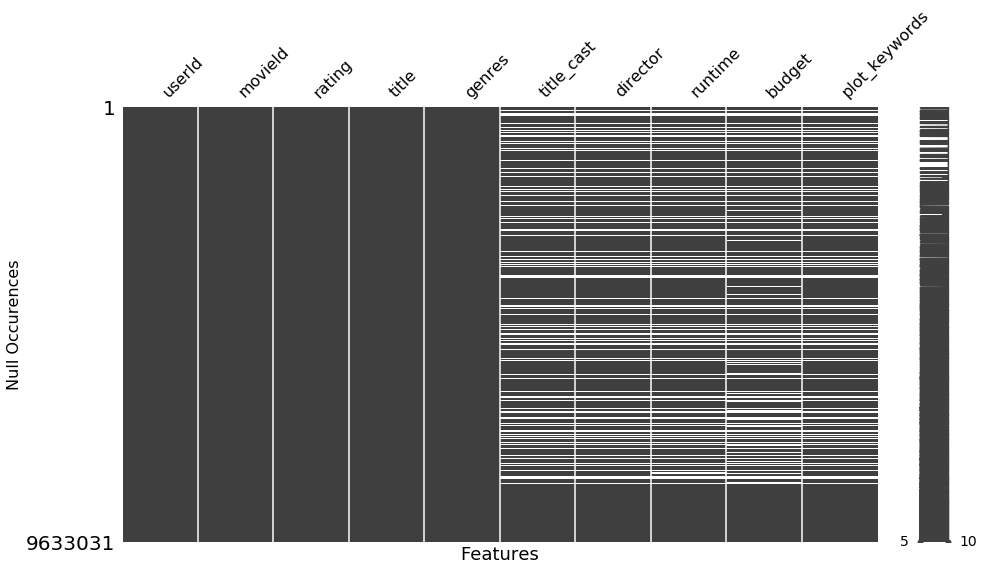

In [10]:
missingno.matrix(data, figsize=(15,8))
plt.xlabel('Features', fontsize=18)
plt.ylabel('Null Occurences', fontsize=16)
plt.show()

As we can see from the visual above, the ***budget***, ***runtime***, ***title_cast*** and **director** columns have missing values. But this does not give any information on how many rows in these columns have missing values. We'll use the function defined below to show the number of missing values in each of the identified columns and what percentage of the data is missing.

In [11]:
def missing_values_table(df):
  '''
  Identify and show the missing values in a data set.
  params: df (dataframe)
  returns: renamed_columns (dataframe)
  '''

  mis_val = df.isnull().sum()
    
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  
  renamed_columns = mis_val_table.rename(columns = 
                                         {0 : 'Missing Values',
                                          1: '% of Total Values'})
  
  renamed_columns = renamed_columns[renamed_columns.iloc[:,1] != 0]

  renamed_columns = renamed_columns.sort_values('% of Total Values',ascending=False)
  
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\nThere are " 
         + str(renamed_columns.shape[0]) + " columns that have missing values.")
  
  # Return the dataframe with missing information
  return renamed_columns


In [12]:
missing_values_table(data)

Your selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
budget,3152276,32.72
runtime,2653058,27.54
plot_keywords,2610043,27.09
title_cast,2604407,27.04
director,2602688,27.02


The number of missing values in these columns is not so high that it could affect our analysis of the data. The only column we will be using that will be affected is the ***runtime*** column. What we will do is  impute all the missing values in this column with the mean of the data

In [4]:
data['runtime'].fillna(data['runtime'].mean(), inplace=True)

As we can see below, the ***runtime*** column does not appear to be on the list of columns with missing values.

In [14]:
missing_values_table(data)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
budget,3152276,32.72
plot_keywords,2610043,27.09
title_cast,2604407,27.04
director,2602688,27.02


#EDA
In this section we look at how our features interact to and relate with each other. The features we will be using in our analysis are:

- Title
- Title Cast
- Runtime
- Director
- Genres
- Year, which we will create
- Plot Keywords

## What is the most rated movie?

In [5]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = data[data['title'].isin(data[data.duplicated(['title'])]['title'])]
result.sort_values('title')

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords
9532427,156067,51372,0.5,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.0,NaN,ballet|aging|kidnapping|magician
9532422,28522,51372,2.5,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.0,NaN,ballet|aging|kidnapping|magician
9532423,22836,51372,5.0,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.0,NaN,ballet|aging|kidnapping|magician
9532424,39162,51372,3.5,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.0,NaN,ballet|aging|kidnapping|magician
9532425,47571,51372,0.5,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.0,NaN,ballet|aging|kidnapping|magician
...,...,...,...,...,...,...,...,...,...,...
9609333,72315,130640,2.0,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.0,NaN,entering tv screen|screaming woman|screaming i...
9609332,71897,130640,4.0,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.0,NaN,entering tv screen|screaming woman|screaming i...
9609331,71265,130640,4.0,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.0,NaN,entering tv screen|screaming woman|screaming i...
9609330,73268,130640,1.0,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.0,NaN,entering tv screen|screaming woman|screaming i...


In [6]:
# Most rated titles
most_rated = pd.DataFrame(result.groupby('title')['rating']
                          .count()
                          .sort_values(ascending=False)).reset_index()

In [7]:
most_rated = most_rated.rename(columns={"rating": "num_of_ratings"})
most_rated.reindex()
most_rated.head()

,title,num_of_ratings
0,"Shawshank Redemption, The (1994)",32831
1,Forrest Gump (1994),32383
2,Pulp Fiction (1994),31697
3,"Silence of the Lambs, The (1991)",29444
4,"Matrix, The (1999)",29014


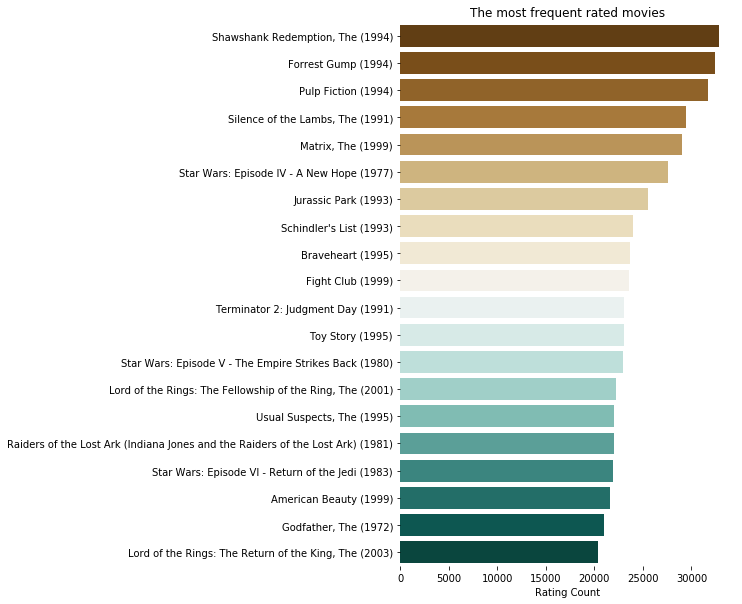

In [8]:
# plot the highest rated movies
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=most_rated[0:20],y='title',x='num_of_ratings',palette = sns.color_palette("BrBG", 20))
ax.set(ylabel="",
       xlabel="Rating Count")
ax.title.set_text('The most frequent rated movies')
sns.despine(left=True, bottom=True)

In [9]:
rated = pd.DataFrame(result.groupby('title')['rating']
                          .mean()
                          .sort_values(ascending=False)).reset_index()

In [10]:
rated

,title,rating
0,Favor (2013),5.00
1,Excuse Me for Living (2012),5.00
2,Limuzins Janu nakts krasa (1981),5.00
3,Crazy Mama (1975),4.75
4,Remarkable Power (2008),4.75
...,...,...
21632,Blutzbrüdaz (2013),0.50
21633,"Oh, Susanna! (1936)",0.50
21634,"Ah of Life, The (2010)",0.50
21635,Tyler Perry's A Madea Christmas (2011),0.50


In [11]:
rated['count'] = rated.groupby('rating')['rating'].transform('count')

In [ ]:
rated

## Which movies have the shortest and longest runtime?


What is the average runtime for a movie in the data?

In [ ]:
# calculate the average movie duration
round(data['runtime'].mean(),2)

- The average runtime is 116.1. 
- This equates to ~1.9 hours, which is a normal runtime for movies. 

What is the average rating for
- movies longer than 2 hours?
- movies shorter than 2 hours?

In [5]:
# calculate the average star rating for movies 2 hours or longer
# calculate the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', round(data[data['runtime'] >= 120]['rating'].mean(),2), 
 '\nAvg. star rating for movies shorter than 2 hours: ', round(data[data['runtime'] < 120]['rating'].mean(),2))

Avg. star rating for movies 2 hours or longer:  3.66 
Avg. star rating for movies shorter than 2 hours:  3.49


In [6]:
shorter_runtime = data[data['runtime'] <= 248] 

In [7]:
shorter_runtime.head()

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [9]:
def find_minmax(column_name):
  '''
  This function looks at the maximum and minimum profits of the movies,
  then returns the maximum runtime.
  The function uses the function 'idmin' to find the index of lowest profit movie.
  and 'idmax' to find the index of Highest profit movie.
  The function prints the row related to this index.
  params: column name (str)
  returns: highest and lowest runtime info (dataframe)
  '''
  #use the function 'idmin' to find the index of lowest profit movie.
  min_index = shorter_runtime[column_name].idxmin()

  #use the function 'idmax' to find the index of Highest profit movie.
  high_index = shorter_runtime[column_name].idxmax()

  high = pd.DataFrame(shorter_runtime.loc[high_index,:])
  low = pd.DataFrame(shorter_runtime.loc[min_index,:])
  
  #print the movie with high and low profit
  print("Movie Which Has Highest "+ column_name + " : ",shorter_runtime['title'][high_index])
  print("Movie Which Has Lowest "+ column_name + "  : ",shorter_runtime['title'][min_index])
  
  output = pd.concat([high,low],axis = 1)
  # hardcoded, needs to be changed
  output = output.rename(columns={8148250: 'highest runtime ',9438402:'lowest runtime'})
  return output

In [10]:
#call the find_minmax function.
find_minmax('runtime')

Movie Which Has Highest runtime :  My Voyage to Italy (Il mio viaggio in Italia) (1999)
Movie Which Has Lowest runtime  :  Stille Nacht I: Dramolet (1988)


,highest runtime,lowest runtime
userId,160506,124638
movieId,8755,126050
rating,3,2.5
title,My Voyage to Italy (Il mio viaggio in Italia) ...,Stille Nacht I: Dramolet (1988)
genres,Documentary,Animation
title_cast,Martin Scorsese,NaN
director,Suso Cecchi D'Amico,Stephen Quay
runtime,246,1
budget,NaN,NaN
plot_keywords,film history|filmmaking|italian cinema|italian...,magnet|doll|spoon|moth


In [11]:
info = pd.DataFrame(shorter_runtime['runtime'].sort_values(ascending = False))
info['original_title'] = shorter_runtime['title']
info.drop_duplicates(inplace = True)
info.reset_index(drop=True, inplace=True)

In [12]:
info

,runtime,original_title
0,246.0,My Voyage to Italy (Il mio viaggio in Italia) ...
1,244.0,At Berkeley (2013)
2,242.0,Hamlet (1996)
3,240.0,"Beach Boys: An American Family, The (2000)"
4,240.0,Bonnie and Clyde (2013)
...,...,...
23496,1.0,Four Heads Are Better Than One (Un homme de tê...
23497,1.0,The Kiss (1900)
23498,1.0,Dickson Greeting (1891)
23499,1.0,Santa Claus (1898)


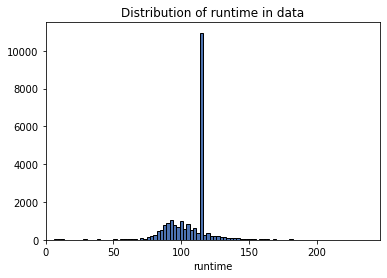

In [13]:
#histogram of the runtimes
plt.hist(info['runtime'], bins = 100, edgecolor = 'k')
plt.xlabel('runtime') 
plt.title('Distribution of runtime in data')
plt.xlim([0,247])
plt.show()

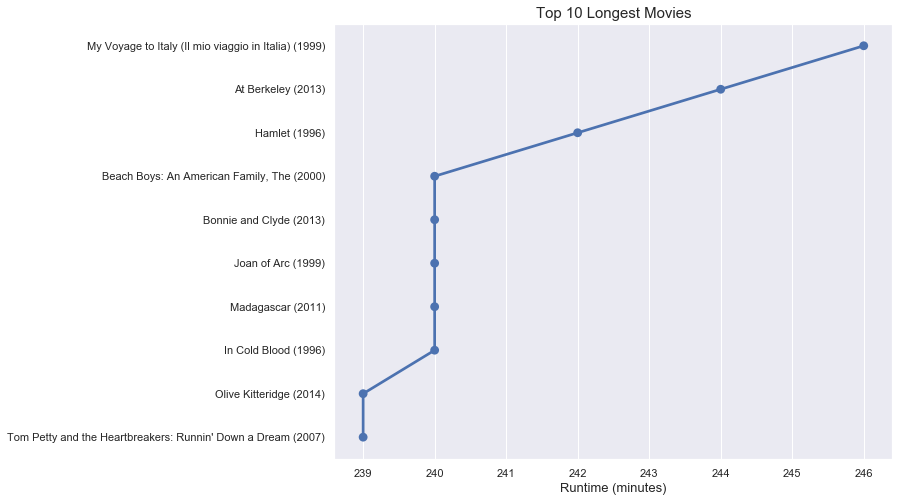

In [19]:
info_list = list(map(str,(info['original_title'])))
movie_titles = list(info_list[:10])
movie_runtimes = list(info['runtime'][:10])

#setup the figure size
sns.set(rc={'figure.figsize':(10,8)})

ax = sns.pointplot(x=movie_runtimes,y=movie_titles)
#setup the title and labels of the plot.
ax.set_title("Top 10 Longest Movies",fontsize = 15)
ax.set_xlabel("Runtime (minutes)",fontsize = 13)
sns.set_style("darkgrid")

## Which year has the highest release of movies?

Before we can do our analysis, we have to extract the year each movie was released from the titles and save them in a new column.

In [20]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don’t conflict with movies that have years in their titles
movies['year'] = movies['title'].str.extract("(\(\d\d\d\d\))",expand=False)
#Removing the parentheses
movies['year'] = movies['year'].str.extract("(\d\d\d\d)",expand=False)
#Removing the years from the ‘title’ column
movies['title'] = movies['title'].str.replace("(\(\d\d\d\d\))", "")
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [21]:
pd.to_datetime(movies.year, format='%Y')

0       1995-01-01
1       1995-01-01
2       1995-01-01
3       1995-01-01
4       1995-01-01
           ...    
62418   2018-01-01
62419   2001-01-01
62420   2018-01-01
62421   2001-01-01
62422   1962-01-01
Name: year, Length: 62423, dtype: datetime64[ns]

In [26]:
year_df = pd.DataFrame(movies.groupby('year')['title'].count()).reset_index()
year_df.rename(columns={'title': 'num_of_titles'}, inplace=True)
year_df = year_df.sort_values(by='year', ascending=False)
year_df

,year,num_of_titles
134,2019,994
133,2018,2034
132,2017,2374
131,2016,2488
130,2015,2513
...,...,...
4,1887,1
3,1883,1
2,1880,1
1,1878,1


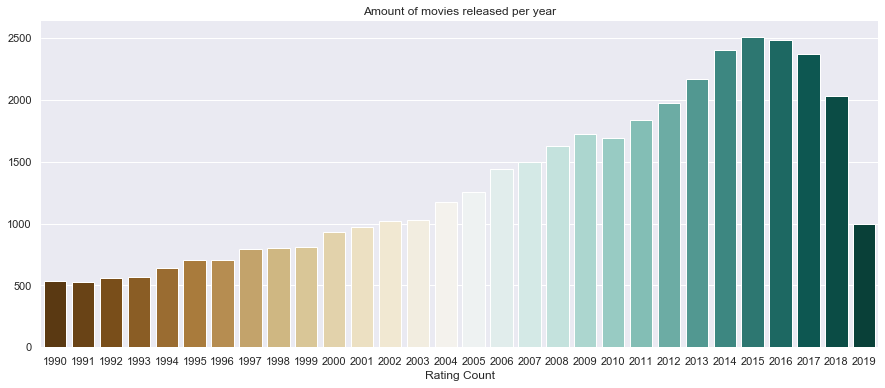

In [33]:
# plot the highest rated movies
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=year_df[0:30],y='num_of_titles',x='year',palette = sns.color_palette("BrBG", 30))
ax.set(ylabel="",
       xlabel="Rating Count")
ax.title.set_text('Amount of movies released per year')
sns.despine(left=True, bottom=True)

In [63]:
def decades(year):
  '''
  This function defines the year based on the decade that it is released.
  params: year (int)
  returns: decade (str)
  '''
  decade = str(floor(year/10))
  return decade+"0s"

In [68]:
year_df['decade'] = year_df['year'].astype(int)
year_df['decade'] = year_df['decade'].apply(decades)
year_df

,year,num_of_titles,decade
134,2019,994,2010s
133,2018,2034,2010s
132,2017,2374,2010s
131,2016,2488,2010s
130,2015,2513,2010s
...,...,...,...
4,1887,1,1880s
3,1883,1,1880s
2,1880,1,1880s
1,1878,1,1870s


In [75]:
yearly_release = year_df.groupby('decade')['num_of_titles'].sum().reset_index()
yearly_release

,decade,num_of_titles
0,1870s,2
1,1880s,7
2,1890s,108
3,1900s,155
4,1910s,239
5,1920s,576
6,1930s,2069
7,1940s,2326
8,1950s,2981
9,1960s,3586


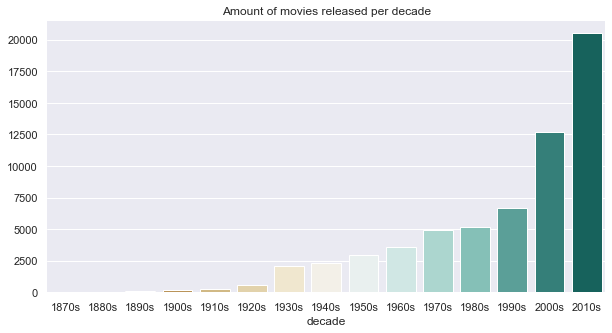

In [86]:
# plot the highest rated movies
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=yearly_release,y='num_of_titles',x='decade',palette = sns.color_palette("BrBG", 16))
ax.set(ylabel="",
       xlabel="decade")
ax.title.set_text('Amount of movies released per decade')
sns.despine(left=True, bottom=True)

In [ ]:
################ NOT WORKING ###########

In [ ]:
trace1 = go.Scatter(x=year_df.year,
                    y=year_df.num_of_titles,
                    name = 'Number of Movies Released per Year, 1874-2019',
                    line = dict(color = 'blue'),
                    opacity = 0.4)

layout = dict(title='Number of Movies Released per Year, 1874-2019',)

fig = dict(data=[trace1], layout=layout)
iplot(fig)
plt.show()

In [ ]:
with sns.axes_style('whitegrid'):
    
    g = sns.catplot("period", data=year_df, aspect=2.0,kind='count')
    g.set_ylabels("Total Number of Movies")
    g.set_xlabels("Time Period")
    plt.title('Distribution of the Number of Movies in Each Time Period')
    plt.xticks(rotation=30)
    #f, ax = plt.subplots(figsize=(25, 8))

## Movie with Longest And Shortest Runtime?

In [ ]:
#find the movie with longest and shortest runtime.
#use 'find_minmax' function which i made earlier by passsing 'runtime' as argument.
#it can't be possible a movie with zero runtime,but dataset contain some data like this.
#so update zero with NAN in runtime column.
data['runtime'] = data['runtime'].replace(0,np.NAN)

## Which Genre Has The Highest Release Of Movies?

In [ ]:
#make a function will will split the string and return the count of each genre.
def count_genre(x):
    #concatenate all the rows of the genres.
    data_plot = data[x].str.cat(sep = '|')
    df = pd.Series(data_plot.split('|'))
    #conts each of the genre and return.
    info = df.value_counts(ascending=False)
    return info

#call the function for counting the movies of each genre.
total_genre_movies = count_genre('genres')
#plot a 'barh' plot using plot function for 'genre vs number of movies'.
total_genre_movies.plot(kind= 'barh',figsize = (13,6),fontsize=12,colormap='tab20c')

#setup the title and the labels of the plot.
plt.title("Genre With Highest Release",fontsize=15)
plt.xlabel('Number Of Movies',fontsize=13)
plt.ylabel("Genres",fontsize= 13)
sns.set_style("whitegrid")

In [ ]:
i = 0
genre_count = []
for genre in total_genre_movies.index:
    genre_count.append([genre, total_genre_movies[i]])
    i = i+1
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(8, 8))
genre_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*genre_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in genre_count]
ax.pie(sizes, labels=labels_selected,
       autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
plt.tight_layout()


### Most Frequent Actor?

In [ ]:
def count_genre(x):
    #concatenate all the rows of the genres.
    data_plot = imdb[x].str.cat(sep = '|')
    df = pd.Series(data_plot.split('|'))
    #conts each of the genre and return.
    info = df.value_counts(ascending=False)
    return info

In [ ]:
#call the 'count_genre' function which we made earlier for spiliing and counting genres.
#it wiil count number of movies done by each actor.
count_actor_films = count_genre('title_cast')

#plot the barh plot.
count_actor_films.iloc[:20].plot.bar(figsize=(13,6),colormap= 'tab20c',fontsize=12)

#setup the title and the labels of the plot.
plt.title("Most Frequent Actor",fontsize=15)
plt.xticks(rotation = 70)
plt.xlabel('Actor',fontsize=13)
plt.ylabel("Number Of Movies",fontsize= 13)
sns.set_style("whitegrid")

### Top 20 Director Who Directs Maximum Movies?

In [ ]:
def count_genre(x):
    #concatenate all the rows of the genres.
    data_plot = imdb[x].str.cat(sep = '|')
    df = pd.Series(data_plot.split('|'))
    #conts each of the genre and return.
    info = df.value_counts(ascending=False)
    return info

In [ ]:
#call the 'count_genre' function which we made earlier for spiliing and counting genres.
#it wiil count number of movies directed by each diretor.
count_director_movies = count_genre('director')

#plot a barh graph
count_director_movies.iloc[:20].plot(kind='bar',figsize=(13,6),fontsize=12)

#setup the title and the labels 
plt.title("Director Vs Number Of Movies",fontsize=15)
plt.xticks(rotation=70)
plt.ylabel("Number Of Movies",fontsize= 13)
sns.set_style("whitegrid")

### Most Popular Keyword?

In [ ]:
#imdb['plot_keywords'] = imdb['plot_keywords'].fillna(imdb['plot_keywords'].mode(), inplace=True)
keywords = count_genre('plot_keywords')

i = 0
keyword_occurences = []
for p in keywords.index:
    keyword_occurences.append([p, keywords[i]])
    i = i+1

In [ ]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


In [ ]:
from wordcloud import WordCloud, STOPWORDS
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='white', 
                      max_words=1628,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')

##How is the training data distributed?

In [ ]:
with sns.axes_style('whitegrid'):
    g = sns.catplot("rating", data=train, aspect=2.0,kind='count', palette = sns.color_palette("BrBG", 10))
    g.set_ylabels("Total number of ratings")
    plt.title('Distribution of the ratings in training data')
print (f'Average rating in dataset: {np.mean(train["rating"])}')

In [ ]:
# The minimum and maximum ratings given by the users
print('The minimum rating given is:',data['rating'].min())
print('The maximum rating given is:',data['rating'].max())

In [ ]:
# Define a function that creates ranges for ratings
def rating_range(rating):
  '''Takes a rating as input and returns the range that the rating is in.
     params: rating (str)
     return: rating range (str)
  '''
  rating = int(rating)
  if rating < 1:    
    return '0-1'
  elif rating <2:
    return'1-2'
  elif rating <3:
    return '2-3'
  elif rating <4:
    return '3-4'
  else:
    return '4-5'

In [ ]:
movie_rating=data.groupby(['title'])['rating'].mean() # agg rating by mean
movie_rating=pd.DataFrame(movie_rating)
movie_rating

In [ ]:
# Generate column to sum number of ratings per title
movie_rating['num of ratings'] = pd.DataFrame(data.groupby('title')['rating'].count())

In [ ]:
movie_rating['range']=movie_rating['rating'].apply(rating_range)

In [ ]:
# Plot scatter plot illustrating the relationship between ratings and number of ratings
sns.set(style="whitegrid", context="talk")
f, ax = plt.subplots(figsize=(15, 8))
hue_legend=['0-1','1-2','2-3','3-4','4-5']
sns.scatterplot(x=movie_rating['rating'], y=movie_rating['num of ratings'],hue_order=hue_legend,
                hue = movie_rating['range'],palette="husl",sizes=(1, 8),linewidth=0.5,
                data=movie_rating, ax=ax)
plt.xlabel('Ratings') 
plt.ylabel('Total Ratings')
plt.title('Clustered ratings based on the amount of ratings') 
plt.show()

#Modelling

A recommender system functions by predicting a user's rating or preference for an item.

There are two primary sets of entities:
- the Users ( individuals who interact with the items)
- the Items (a thing which is consumed)


Items can be:
- watched
- read
- bought
- clicked-on
- considered.


Items are passive, meaning that their properties or nature does not change.

Users create ratings for specific items within a recommendation system.

There are two approaches to recommending movies:
 - collaborative based filtering
 - content based filtering

## Collaborative based prediction
A reader is needed in order to input `rating_scale` parameter

In [ ]:
reader = Reader(rating_scale=(1, 5))

 - Load data into format that Surprise understands using Dataset class from surprise
 - The columns must correspond to user id, item id and ratings (in that order).

In [ ]:
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

We can now use this dataset as we please, e.g. calling cross_validate

In [ ]:
# We are using the full train dataset to train the model here - should use test and train split in order to evaluate
trainset = data.build_full_trainset()

### SVD model

In [ ]:
# Build an algorithm, and train it.
algo = SVD()
algo.fit(trainset)

In [ ]:
# Pickle model
model_save_path = "SVD_full_dataset.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(algo,file)

Example on how to predict using the SVD algorithm

In [ ]:
# raw user id (as in the ratings file). They are **strings**!
uid = str(1)
# raw item id (as in the ratings file). They are **strings**!
iid = str(2011)

Get a prediction for specific users and items.

In [ ]:
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

Get a prediction for the test data

In [ ]:
test_df = pd.read_csv('Documents/movies/test.csv')

In [ ]:
# Predict on our test data
predcol = []
for _, row in test_df.iterrows():
    x = (algo.predict(row.userId, row.movieId))
    pred = x[3]
    predcol.append(pred)

In [ ]:
# check if the prediction length is the same as input length
len(predcol) == len(test_df)

In [ ]:
# Convert columns to string in order to prep for concatenating
test_df['userId'] = test_df['userId'].astype(str)
test_df['movieId'] = test_df['movieId'].astype(str)

In [ ]:
# Create submission column ID
test_df['Id'] =test_df['userId']+'_'+test_df['movieId']

In [ ]:
kaggle_df = pd.DataFrame(
    {'Id': test_df['Id'],
     'rating': predcol
    })

In [ ]:
kaggle_df.shape

In [ ]:
kaggle_df.head()

In [ ]:
# Export to csv
kaggle_df.to_csv("SVD_base.csv",index=False)

## Content based prediction
In Content-based Filtering, we seek to make recommendations based on how similar the properties or features of an item are to other items.

In [ ]:
# Not sure where df is created in notebook
# will create it again
# need to just recheck the flow of notebook

In [ ]:
# Generate a dataframe df by mergin the train, movies and imdb datsets on movieId
df=pd.merge(movies,train,how='outer',on='movieId') # movies and train outer join
df=pd.merge(df,imdb,how='left',on='movieId') # movies and train left join

In [ ]:
del movies
del imdb

In [ ]:
column_list=['timestamp','runtime','budget','plot_keywords']
df.drop(column_list,axis=1,inplace=True)

In [ ]:
# Check df shape
row,column=df.shape
print('The dataframe has {} rows and {} columns.'.format(row, column))

In [ ]:
df.head(5)

In [ ]:
# Function takes in text as input and removes pipe
def remove_pipe(text):
  text=str (text)
  text=text.replace("|",",")
  return text

In [ ]:
# Apply remove_pipe to columns title_cast and genres
df['genres']=df['genres'].fillna('') #fill missing values with blanks
df['title_cast']=df['title_cast'].fillna('') #fill missing values with blanks

df['title_cast']=df['title_cast'].apply(remove_pipe) #apply remove_pipe sunction
df['genres']=df['genres'].apply(remove_pipe)
df.head()

Taking the df dataframe. A filtered dataframe with unique movie titles can be generated to remove duplicate movie titles due to multiple user ratings.

In [ ]:
# A content column can be generated from the title_cast and genres columns
# This column will be used to build the content recommender

df['content']=df['genres']+' '+ df['title_cast'] 
df['content'][0]

In [ ]:
# A ratings dataframe can be generated from uniw\que movie titles and their average ratings across all users
ratings=df.groupby(['title'])['rating'].mean() #group by title and aggregate ratings
ratings=pd.DataFrame(ratings)
ratings=ratings.fillna(2) # fill missing values with generic score of 2 (40%)
ratings['num of ratings']=df.groupby(['title'])['rating'].count() #generate a column witht the total number of ratings
ratings.head(5)

In [ ]:
content=df.groupby(['title'])['content'].unique() #group by title and display unique values in a list
content=pd.DataFrame(content)
content.head(5)

In [ ]:
# Generate single dataframe
movie_df=pd.merge(ratings,content,on='title') #join on index
row,column=movie_df.shape
print('The dataframe has {} rows (representing unique movie titles) and {} columns.'.format(row, column))
movie_df.head(5)

In [ ]:
del content
del ratings

In [ ]:
# Sort move_df from highest to lowest num of ratings
movie_df=movie_df.sort_values('num of ratings',ascending=False)
movie_df.head(5)

In [ ]:
# Function will remove items from lists into strings
def string(input):
  string=' '
  for i in input:
    string=string+str (i)
  return string

In [ ]:
# Generate strings from lists
movie_df['content']=movie_df['content'].apply(string) #generate strings
movie_df['content'][1]

The movie_df dataframe is the base from which the recommender is built. 

The content column will be the feature used, which will be vectorized and converted to a similarity matrix mxm

In [ ]:
# A subset of the movies will be used. The greater the subset, the more memory is committed
# The cosine similiarity size is proportional to feature size
#First 15000 movies are selected
feature=movie_df['content'][0:15000]

In [ ]:
# Set up vectorizer
vec=TfidfVectorizer(stop_words='english') # term frequency inverse document frequency

In [ ]:
# Vectorize combined column
feature_vec=vec.fit_transform(feature)
row,column=feature_vec.shape
print('feature_vec is a sparse matrix with {} rows (representing unique movie titles) and {} columns.'.format(row, column))


The cosine similarity will be used to determine how similar two entities are based off the angle between their two vectors formed. The closer a value is to 1, to higher the similarity

The cosine similarity is formed from the dot product of the feature_vec matrix and its transpose divided by the product of their magniudes.

In [ ]:
# Use cosine similarity to get similarity matrix
sim_matrix =cosine_similarity(feature_vec,feature_vec)
row,column=sim_matrix.shape
print('The sim_mat matrix has {} rows and {} columns.'.format(row, column))

In [ ]:
# Double check
# Reset the move_df index as it will be used to generate a Series that will map sim_mat
movie_df=movie_df.reset_index()
movie_df.head(5)

In [ ]:
# Index mapping
index_map = pd.Series(movie_df.index,index = movie_df['title']) # contains a series of the movie titles in movie_df
index_map

In [ ]:
# Function takes in a movie title as an input and returns 10 movie title recommendations

def recommendation(title):
  index = index_map[title] # returns the index of the argument title in index_map
  similarity = list(enumerate(sim_matrix[index])) # returns a list of with index and similarity
  similarity = sorted(similarity, key=lambda x: x[1], reverse=True) # sorts list in descending order
  similarity = similarity[1:11] # top 10 recommendations
  #return movie names using the mapping series
  movie_indices = [i[0] for i in similarity] # obtain indices for recommended movies
  return (movie_df['title'].iloc[movie_indices]) # filter movie_df for titles

Using the animated movie Aladin from 1992. The recommender returns viewing options consisting of animated movies such as Moana, Minions and Dragons: Dawn Of The Dragon Racers.



In [ ]:
# Lets search for recommendations based off Aladdin
recommendations=recommendation('Aladdin (1992)')
recommend_list=list(recommendations)
recommend_list

In [ ]:
# pickle recommendation function
model_save_path = "content_based.pkl"
with open(model_save_path,'wb') as file:
  pickle.dump(recommendation,file)

In [ ]:
#test content-based predictor
print("testing content based recommender")
model_load_path = "content_based.pkl"
with open(model_load_path,'rb') as file:
  content_based_predict = pickle.load(file)
  print(content_based_predict('Aladdin (1992)'))   

In addtion. We can predict what a user would rate the movie watched based off previous ratings given.


In [ ]:
# Recall df and sort based in descending order of movie rating
df=df.sort_values('rating',ascending=False)
df.head()

In [ ]:
# Function predict a user rating for a particular title

def user_rating(title, userId, df, k=20, threshold=0.0):
    

    index = index_map[title] # returns the index of the argument title in index_map

    similar_titles = [] # List to append similar titles to 

    # Collect the similarity ratings between the movies rated by userid
    
    for idx, row in df[df['userId']==userId].iterrows():
        similarity = sim_matrix[index-1, index_map[row['title']]-1]
        similar_titles.append((similarity, row['rating']))
        
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k,similar_titles, key=lambda t: t[0])

    # Compute the weighted average similarity and user ratings
    Total, weight = 0, 0
    for (sim_score, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (sim_score > threshold):
            Total += sim_score
            weight += sim_score * rating
            
        prediction = weight/Total

    return round(prediction,1)

Testing the above function for user 137780 and the movie Toy Story, we obtain a predicted rating of 4.6

In [ ]:
user_rating('Jerry Maguire (1996)',4224.0,df)

# Recommender Comparison

Both recommenders have the ability to provide recommendations to users as well as predict a rating that a user would give, but when comparing the difference in output for the same inputs we get the following

In [ ]:
users=list(df.iloc[2:10,3]) # List of users for comparison
users

The dataframe below illustrates the difference in movie recommendations for the collaborative and content based models. The movie selected is '' and the top 10 recommendations given by the recommenders are shown

In [ ]:
ratings_list=[]

#delete filler. This is to fill in the dataframe while we wait for collab information 
# Colab code must be added
from numpy import random
filler=random.randint(5, size=(8))

for i in users:
  
  ratings_list.append(user_rating('Forrest Gump (1994)',i,df))

user_dataframe=pd.DataFrame(data={'user':users,'content based ratings':ratings_list,'collaborative based ratings':filler})
user_dataframe

In [ ]:
# Plot comparison

X=range(0,8) # Use range to represent number of users

sns.set(style="whitegrid", context="talk")
f, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x=X, y="content based ratings", data=user_dataframe,color="coral", label="Content based") # Content based plot
sns.lineplot(x=X, y="collaborative based ratings", data=user_dataframe,color="blue", label="Colab based") # Collaborative based plot
plt.xlabel('Users') 
plt.ylabel('Ratings')
plt.title('Recommender System Prediction Comparison') 

plt.show()

Similary when getting recommendations for the action movieDouble Team, the two systems provide the following.

In [ ]:
# Recommendation code for each model

# Colab code must be added


recommendations=list(recommendation('Double Team (1997)')) # Content system recommendations



In [ ]:
recommendation_comparison=pd.DataFrame(data={'content based recommedations':recommendations,'collaborative based model':recommendations})
recommendation_comparison

# Comet version control

In [ ]:
# Comet logging

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment# Create dictionaries for comet

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment